<a href="https://colab.research.google.com/github/anuj0456/deep_learning_for_coders/blob/master/numerai/numerai_round_264.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/ML/numerai/numerai_datasets.zip

Archive:  /content/drive/MyDrive/ML/numerai/numerai_datasets.zip
replace numerai_training_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
import numpy as np
import pandas as pd
import xgboost as xgb 
import tensorflow as tf
import lightgbm as lgbm
from xgboost import DMatrix
from functools import partial
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [6]:
df_train = pd.read_csv("numerai_training_data.csv")
df_train.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.5,1.00,0.50,0.75,0.25,0.50,0.0,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.5,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [7]:
df_test = pd.read_csv("numerai_tournament_data.csv")
df_test.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [8]:
print(df_train.shape)
print(df_test.shape)

(501808, 314)
(1725602, 314)


In [9]:
# There's 310 features
features = [c for c in df_train if c.startswith("feature")]
df_train["erano"] = df_train.era.str.slice(3).astype(int)
eras = df_train.erano
target = "target"
len(features)

310

In [11]:
# The features are grouped together into 6 types
feature_groups = {g: [c for c in df_train if c.startswith(f"feature_{g}")]
    for g in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]
}
feature_groups

{'charisma': ['feature_charisma1',
  'feature_charisma2',
  'feature_charisma3',
  'feature_charisma4',
  'feature_charisma5',
  'feature_charisma6',
  'feature_charisma7',
  'feature_charisma8',
  'feature_charisma9',
  'feature_charisma10',
  'feature_charisma11',
  'feature_charisma12',
  'feature_charisma13',
  'feature_charisma14',
  'feature_charisma15',
  'feature_charisma16',
  'feature_charisma17',
  'feature_charisma18',
  'feature_charisma19',
  'feature_charisma20',
  'feature_charisma21',
  'feature_charisma22',
  'feature_charisma23',
  'feature_charisma24',
  'feature_charisma25',
  'feature_charisma26',
  'feature_charisma27',
  'feature_charisma28',
  'feature_charisma29',
  'feature_charisma30',
  'feature_charisma31',
  'feature_charisma32',
  'feature_charisma33',
  'feature_charisma34',
  'feature_charisma35',
  'feature_charisma36',
  'feature_charisma37',
  'feature_charisma38',
  'feature_charisma39',
  'feature_charisma40',
  'feature_charisma41',
  'feature_ch

In [10]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return numpy.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return numpy.corrcoef(y_true, y_pred)[0,1]

In [ ]:
# There are 120 eras numbered from 1 to 120
eras.describe()

In [ ]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
df.groupby(eras).size().plot()

In [ ]:
# The target is discrete and takes on 5 different values
df.groupby(target).size()

In [ ]:
feature_corrs = df[features].corr()

In [ ]:
feature_corrs.stack().head()

In [ ]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

### The correlation can change over time
You can see this by comparing feature correlations on the first half and second half on the training set

In [ ]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [ ]:
corr1 = df1[features].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [ ]:
corr2 = df2[features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [ ]:
tdf = pandas.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff")

## Some features are predictive on their own

In [ ]:
feature_scores = {
    feature: numerai_score(df[target], df[feature])
    for feature in features
}

In [ ]:
pandas.Series(feature_scores).sort_values()

In [ ]:
# Single features do not work consistently though
by_era_correlation = pandas.Series({
    era: numpy.corrcoef(tdf[target], tdf["feature_strength34"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

In [ ]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

# Gotcha: MSE looks worse than correlation out of sample
Models will generally be overconfident, so even if they are good at ranking rows, the Mean-Squared-Error of the residuals could be larger than event the Mean-Squared-Error of the target (r-squared<0)

In [ ]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [ ]:
linear1 = linear_model.LinearRegression()
linear1.fit(df1[features], df1[target])
linear2 = linear_model.LinearRegression()
linear2.fit(df2[features], df2[target])

In [ ]:
# Note in particular that the R-squared of (train_on_1, eval_on_2) is slightly negative!
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pandas.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

In [ ]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent
corrs = [
    [
        numerai_score(dfX[target], pandas.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pandas.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

In [ ]:
xgb1 = xgboost.XGBRegressor()
xgb1.fit(df1[features], df1[target])
xgb2 = xgboost.XGBRegressor()
xgb2.fit(df2[features], df2[target])

In [ ]:
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [xgb1, xgb2]
]
pandas.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

In [ ]:
corrs = [
    [
        numerai_score(dfX[target], pandas.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [xgb1, xgb2]
]
pandas.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

# Gotcha:  {0, 1} are noticeably different from {0.25, 0.75}
This makes training a classifier one-versus-rest behave counterintuitively.

Specifically, the 0-vs-rest and 1-vs-rest classifiers seem to learn how to pick out extreme targets, and their predictions are the most correlated

In [ ]:
# Train a standard logistic regression as a classifier
logistic = linear_model.LogisticRegression()
logistic.fit(df[features], (df[target]*4).astype(int))
logistic.score(df[features], (df[target]*4).astype(int))

/home/ubuntu/.local/lib/python3.6/site-packages/scikit_learn-0.21.2-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/scikit_learn-0.21.2-py3.6-linux-x86_64.egg/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.2623872078563913

array([[ 1.        , -0.88666303, -0.93134968, -0.95005346,  0.87165725],
       [-0.88666303,  1.        ,  0.8862373 ,  0.8450147 , -0.948354  ],
       [-0.93134968,  0.8862373 ,  1.        ,  0.86030322, -0.95002613],
       [-0.95005346,  0.8450147 ,  0.86030322,  1.        , -0.86180891],
       [ 0.87165725, -0.948354  , -0.95002613, -0.86180891,  1.        ]])

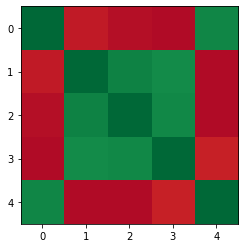

In [ ]:
# The first and last class are highly correlated
corrs=numpy.corrcoef(logistic.predict_proba(df[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

In [ ]:
# In-sample correlation is 5.4%
preds = pandas.Series(logistic.predict_proba(df[features]).dot(logistic.classes_), index=df.index)
numerai_score(df[target], preds)

0.054008721403805166

In [ ]:
# A standard linear model has a slightly higher correlation
linear = linear_model.LinearRegression()
linear.fit(df[features], df[target])
linear.score(df[features], df[target])
preds = pandas.Series(linear.predict(df[features]), index=df.index)
numerai_score(df[target], preds)

0.0541934330359845

# Gotcha: eras are homogenous, but different from each other
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of 4.3%, but a time series split reports a lower score of 3.4%

In [ ]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    model_selection.TimeSeriesSplit(5)
]

In [ ]:
def correlation_score(y_true, y_pred):
    return numpy.corrcoef(y_true, y_pred)[0,1]

In [ ]:
for cv in crossvalidators:
    print(cv)
    print(numpy.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)
0.03658489467457003

KFold(n_splits=5, random_state=None, shuffle=True)
0.04360860798952288

GroupKFold(n_splits=5)
0.038069863851659315

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.033943838232674675



## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 10, training on each block, and evaluating on each other block.

In [ ]:
eras10 = (eras // 10) * 10
eras10.value_counts()

50     48186
60     46831
100    46107
90     45609
110    45070
80     43971
40     43439
30     41101
70     40403
20     37444
10     34600
0      24515
120     4532
Name: erano, dtype: int64

In [ ]:
results10 = []
for train_era, tdf in df[eras10<120].groupby(eras10):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df[eras10<120].groupby(eras10):
        results10.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

0
10
20
30
40
50
60
70
80
90
100
110


In [ ]:
results_df = pandas.DataFrame(
    results10,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,10,20,30,40,50,60,70,80,90,100,110
train_era,,,,,,,,,,,,
0,0.146423,0.036963,0.038011,0.034264,0.025910,0.009744,0.002876,0.037817,0.029892,0.033866,0.019426,0.004162
10,0.042831,0.119715,0.034830,0.033846,0.035863,0.003364,0.006552,0.033276,0.034233,0.038309,0.023926,0.014590
20,0.043862,0.040213,0.123154,0.036627,0.023993,0.009394,0.000732,0.027858,0.016508,0.035827,0.021159,0.007964
30,0.043145,0.040596,0.043468,0.108705,0.037635,0.023734,0.007650,0.046880,0.023781,0.039757,0.010581,0.010506
40,0.039806,0.044743,0.029963,0.037634,0.098834,0.014143,0.007886,0.035910,0.028617,0.031637,0.008431,0.019615
50,0.017756,0.006481,0.011675,0.025233,0.014928,0.106223,0.009696,0.017742,0.002873,0.018168,0.014381,0.016401
60,0.011671,0.016350,0.006663,0.009488,0.009990,0.009639,0.104522,0.017671,0.006228,0.003792,0.004541,0.010718
70,0.039278,0.036966,0.028348,0.034946,0.025443,0.006190,0.010160,0.129820,0.032531,0.035526,0.019330,0.008851
80,0.038294,0.038707,0.017229,0.020259,0.021633,0.000531,0.003182,0.034221,0.108331,0.030059,0.017398,0.006075


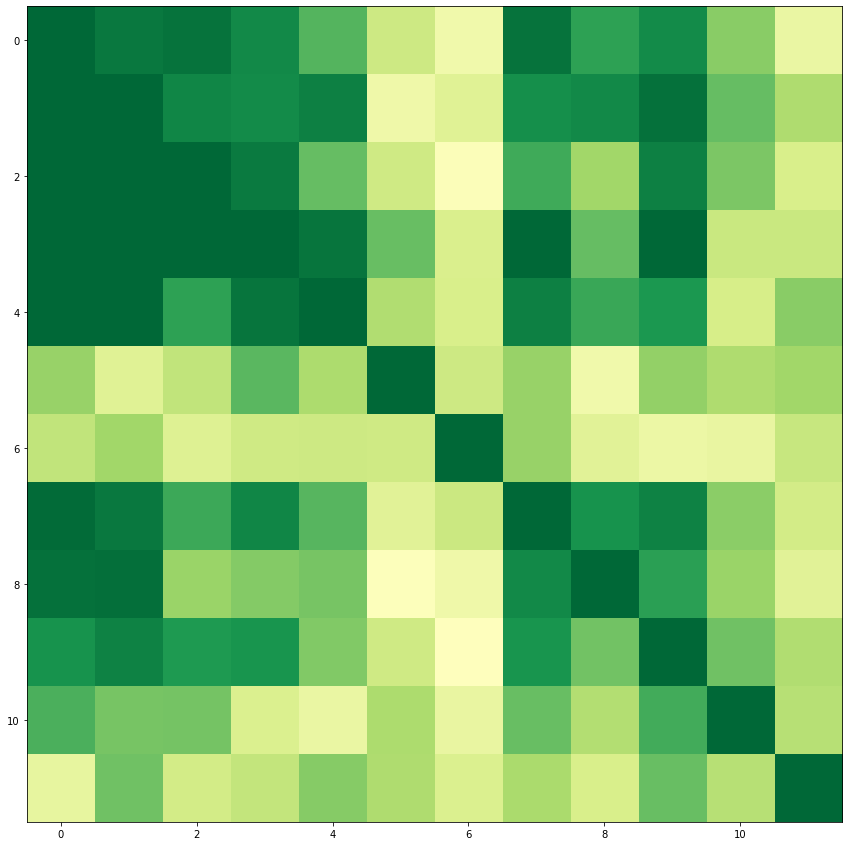

In [ ]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the middle that does not seem to be relevant to other eras, and the
#  overall performance seems to decrease a bit over time.
plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")


Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

## Gotcha: Since the signal-to-noise ratio is so low, models can take many more iterations than expected, and have scarily high in-sample performance

In [ ]:
def our_score(preds, dtrain):
    return "score", -numpy.corrcoef(preds, dtrain.get_label())[0,1]

dtrain = xgboost.DMatrix(df1[features], df1[target])
dtest = xgboost.DMatrix(df2[features], df2[target])
dall = xgboost.DMatrix(df[features], df[target])

/home/ubuntu/.local/lib/python3.6/site-packages/xgboost-0.90-py3.6-linux-x86_64.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/.local/lib/python3.6/site-packages/xgboost-0.90-py3.6-linux-x86_64.egg/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:0.35289	test-rmse:0.353029	train-score:-0.036672	test-score:-0.018971
[10]	train-rmse:0.352604	test-rmse:0.352907	train-score:-0.060901	test-score:-0.030237
[20]	train-rmse:0.352406	test-rmse:0.352849	train-score:-0.070733	test-score:-0.033376
[30]	train-rmse:0.352255	test-rmse:0.352824	train-score:-0.077785	test-score:-0.034502
[40]	train-rmse:0.352109	test-rmse:0.352797	train-score:-0.083381	test-score:-0.036086
[50]	train-rmse:0.351989	test-rmse:0.35279	train-score:-0.088237	test-score:-0.036645
[60]	train-rmse:0.351874	test-rmse:0.352778	train-score:-0.092579	test-score:-0.037602
[70]	train-rmse:0.351769	test-rmse:0.352774	train-score:-0.096485	test-score:-0.038273
[80]	train-rmse:0.35167	test-rmse:0.352771	train-score:-0.099683	test-score:-0.038777
[90]	train-rmse:0.351575	test-rmse:0.352775	train-score:-0.103451	test-score:-0.038894
[100]	train-rmse:0.35148	test-rmse:0.352776	train-score:-0.107079	test-score:-0.039126
[110]	train-rmse:0.351393	test-rmse:0.352776	tr

[940]	train-rmse:0.346621	test-rmse:0.353394	train-score:-0.228575	test-score:-0.040005
[950]	train-rmse:0.346571	test-rmse:0.353398	train-score:-0.229612	test-score:-0.040051
[960]	train-rmse:0.346527	test-rmse:0.353403	train-score:-0.230449	test-score:-0.040087
[970]	train-rmse:0.346479	test-rmse:0.353415	train-score:-0.231366	test-score:-0.039987
[980]	train-rmse:0.346428	test-rmse:0.353426	train-score:-0.232327	test-score:-0.039943
[990]	train-rmse:0.34638	test-rmse:0.353433	train-score:-0.233212	test-score:-0.039949
[999]	train-rmse:0.34634	test-rmse:0.353429	train-score:-0.234118	test-score:-0.040008


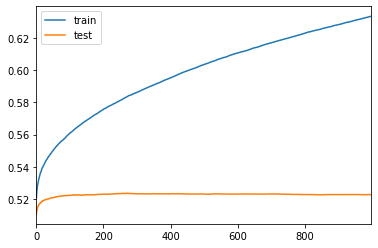

In [ ]:
param = {
    'max_depth':3,
    'eta':0.1,
    'silent':1,
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'nthread': -1,
}
evals_result = {}
bst = xgboost.train(
    params=param,
    dtrain=dtrain,
    feval=our_score,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    evals_result=evals_result,
    verbose_eval=10,
)

(0.5 - 0.57*pandas.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot()

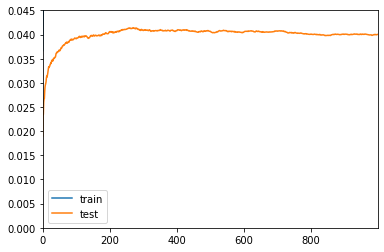

In [ ]:
(-pandas.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot(ylim=[0,0.045])

# The results are sensitive to the choice of parameters, which should be picked through cross-validation

In [ ]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [ ]:
models = [
    linear_model.LinearRegression(),
] + [
    linear_model.ElasticNet(alpha=alpha)
    for alpha in [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001]
] + [
    xgboost.XGBRegressor(n_jobs=-1),
    xgboost.XGBRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000),
    xgboost.XGBRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000),
    xgboost.XGBRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000, max_depth=5),
    xgboost.XGBRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.001, n_estimators=10000, max_depth=5),
]

In [ ]:
for model in models:
    print(" -- ", model)   
    model.fit(df1[features], df1[target])
    outsample = numerai_score(df2[target], pandas.Series(model.predict(df2[features]), index=df2.index))
    insample = numerai_score(df1[target], pandas.Series(model.predict(df1[features]), index=df1.index))
    print(
        f"outsample: {outsample}, insample: {insample}"
    )
    print()

 --  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
outsample: 0.03099809450665611, insample: 0.06588644281475838

 --  ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
outsample: 0.001706090379087756, insample: 0.003084687498966189

 --  ElasticNet(alpha=0.005, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
outsample: 0.001706090379087756, insample: 0.003084687498966189

 --  ElasticNet(alpha=0.002, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
outsample: 0.02296653186

/home/ubuntu/.local/lib/python3.6/site-packages/xgboost-0.90-py3.6-linux-x86_64.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/.local/lib/python3.6/site-packages/xgboost-0.90-py3.6-linux-x86_64.egg/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:59:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
outsample: 0.03822459435002261, insample: 0.10372868743447641

 --  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
[19:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
outsample: 0.0387815520050224, insample: 0.1055617044604215

 --  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamm

## Gotcha: Models with large exposures to individual features tend to perform poorly or inconsistently out of sample ## 


In [ ]:
import numpy as np
import scipy

In [ ]:
# Train a standard xgboost on half the train eras
xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01, n_jobs=-1)
xgb.fit(df1[features], df1[target])
xgb_preds = xgb.predict(df2[features])

[21:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Our predictions have correlation > 0.2 in either direction for some single features!
Sure hope those features continue to act as they have in the past!

In [ ]:
corr_list = []
for feature in features:
    corr_list.append(numpy.corrcoef(df2[feature], xgb_preds)[0,1])
corr_series = pandas.Series(corr_list, index=features)
corr_series.describe()

count    310.000000
mean       0.046897
std        0.084379
min       -0.271691
25%        0.007401
50%        0.044329
75%        0.101984
max        0.220213
dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def _neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    scores = scores - proportion * exposures.dot(numpy.linalg.pinv(exposures).dot(scores))
    return scores / scores.std(ddof=0)
def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)
def normalize_and_neutralize(df, columns, by, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, proportion)
    return df[columns]

In [ ]:
df2["preds"] = xgb_preds
df2["preds_neutralized"] = df2.groupby("era").apply(
    lambda x: normalize_and_neutralize(x, ["preds"], features, 0.5) # neutralize by 50% within each era
)
scaler = MinMaxScaler()
df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

### Now our single feature exposures are much smaller

In [ ]:
corr_list2 = []
for feature in features:
    corr_list2.append(numpy.corrcoef(df2[feature], df2["preds_neutralized"])[0,1])
corr_series2 = pandas.Series(corr_list2, index=features)

In [ ]:
corr_series2.describe()

count    310.000000
mean       0.036216
std        0.055772
min       -0.174678
25%        0.009870
50%        0.034649
75%        0.073136
max        0.150736
dtype: float64

### Our overall score goes down, but the scores are more consistent than before. This leads to a higher sharpe

In [ ]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.0413834154777531
score for balanced feature expo: 0.03633214642701158
std for high feature exposure: 0.04021166505490904
std for balanced feature expo: 0.0318307699959389
sharpe for high feature exposure: 1.0291395648810868
sharpe for balanced feature expo: 1.1414158825453165


In [ ]:
balanced_scores_per_era.describe()

count    56.000000
mean      0.036332
std       0.031831
min      -0.051360
25%       0.015198
50%       0.036021
75%       0.058698
max       0.101365
dtype: float64

In [ ]:
unbalanced_scores_per_era.describe()

count    56.000000
mean      0.041383
std       0.040212
min      -0.077937
25%       0.014694
50%       0.044316
75%       0.066439
max       0.125521
dtype: float64